<p style="text-align: center; font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;">
LoRaWAN Indoor Distance estimation via Log-Distance Path Loss & Shadow Modeling: Kalman Filtering and MLR
</p>

# Overview

This notebook presents an end-to-end framework for enhancing wireless localization through advanced signal processing and propagation modeling. We tackle the inherent noise in Received Signal Strength Indicator (RSSI) measurements by applying a one-dimensional [Kalman filter](https://ani.stat.fsu.edu/~jfrade/HOMEWORKS/STA5107/presentation/sta5107-present/Kalman%20Filter/papers/kalman.pdf) — a recursive Bayesian estimator introduced by Kalman (1960). The filtered RSSI values are then used to calibrate robust [COST231](https://op.europa.eu/en/publication-detail/-/publication/f2f42003-4028-4496-af95-beaa38fd475f) path loss models that account for both structural and environmental influences on signal propagation.

**Key components of this notebook include:**

- **Data Preprocessing & Visualization:**  
  We load a comprehensive dataset of sensor measurements, perform an 80-20 stratified train-test split, and visualize the effect of Kalman filtering on RSSI data across multiple devices.

- **Kalman Filtering:**  
  A detailed cell implements the Kalman filter using the `pykalman` library. The full state-space equations are:
  
  $$
  \begin{aligned}
  x_{k} &= x_{k-1} + w_{k}, \quad w_{k} \sim \mathcal{N}(0, Q), \\
  z_{k} &= x_{k} + v_{k}, \quad v_{k} \sim \mathcal{N}(0, R),
  \end{aligned}
  $$
  
  where $x_k$ represents the latent RSSI and $z_k$ is the observed signal.

- **Path Loss Modeling & Distance Estimation:**  
  We extend the classical log-distance equation under the COST231 model for a single-floor scenario by incorporating wall losses as a summation over categorical wall types. The extended model is:

  $$
  PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + \sum_{i=1}^{K} W_i\,L_i + \epsilon,
  $$

  where:
  - $PL(d_0)$ is the reference path loss at a close-in distance $d_0$,
  - $n$ is the path loss exponent,
  - $d$ is the distance,
  - $K$ is the total number of distinct wall categories (e.g., concrete, wooden),
  - $W_i$ is the count of walls of type $i$,
  - $L_i$ is the attenuation factor for wall type $i$, and
  - $\epsilon$ captures the random shadowing effects.

  
  which is later extended to incorporate additional dynamic environmental parameters (e.g., temperature, humidity, etc.).

- **Model Evaluation & Visualization:**  
  Finally, we compare model performance (using metrics such as RMSE, $R^2$, and the standard deviation of shadowing) across raw and filtered RSSI inputs. Visualizations include scatter plots, histograms, and cumulative distribution functions (CDFs) to assess the models' predictive capabilities.


In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit 
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
# Load data and convert time column
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934284 entries, 0 to 934283
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   time         934284 non-null  datetime64[ns, UTC]
 1   device_id    934284 non-null  object             
 2   co2          934284 non-null  float64            
 3   humidity     934284 non-null  float64            
 4   pm25         934284 non-null  float64            
 5   pressure     934284 non-null  float64            
 6   temperature  934284 non-null  float64            
 7   rssi         934284 non-null  float64            
 8   snr          934284 non-null  float64            
 9   SF           934284 non-null  int64              
 10  frequency    934284 non-null  float64            
 11  f_count      934284 non-null  float64            
 12  p_count      934284 non-null  float64            
 13  toa          934284 non-null  float64            
 14  dist

In [3]:
# 80-20 stratified train-test split ensuring all 6 devices are included in both sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['device_id'], random_state=200)

# Sort by time for clarity in plotting
train_df = train_df.sort_values('time')
test_df = test_df.sort_values('time')

### Introduction to Kalman Filtering

Kalman filtering provides an optimal estimation framework for linear systems corrupted by Gaussian noise.
The filter recursively computes the predicted state and its uncertainty, then updates these estimates with new observations through:

$$
K_k = \frac{P_{k|k-1}}{P_{k|k-1} + R}, \quad \hat{x}_k = \hat{x}_{k|k-1} + K_k (z_k - \hat{x}_{k|k-1})
$$

where $K_k$ is the Kalman gain and $P_{k|k-1}$ is the predicted covariance. This methodology mitigates transient measurement anomalies and refines the quality of the RSSI input for subsequent modeling tasks.


from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define search space
space = [Real(0.001, 0.1, name='Q'), Real(0.1, 2.0, name='R')]

# Objective function: Minimize RSSI std dev after filtering
@use_named_args(space)
def kalman_objective(Q, R):
    kf = KalmanFilter(
        initial_state_mean=train_df['rssi'].iloc[0],
        transition_covariance=Q,
        observation_covariance=R
    )
    filtered_rssi = kf.smooth(train_df['rssi'].values)[0].flatten()
    return np.std(filtered_rssi)

# Run optimization
res = gp_minimize(kalman_objective, space, n_calls=50, random_state=0)
print(f"Optimal Q: {res.x[0]:.4f}, R: {res.x[1]:.4f}")

In [4]:
# Define Kalman filter function and apply it separately on train and test sets per device
def kalman_filter_rssi(rssi_measurements):
    """
    Applies a simple 1D Kalman filter (random-walk model) to RSSI measurements.
    """
    kf = KalmanFilter(
        initial_state_mean=rssi_measurements[0],
        observation_covariance=0.3,
         # observation_covariance=2.0,
        transition_covariance=0.01
    )
    # kf.smooth returns (smoothed_state_means, smoothed_state_covariances)
    return kf.smooth(rssi_measurements)[0].flatten()

# Apply Kalman filter on training data per device
train_df['filtered_rssi'] = train_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)
# Compute exp_pl_filtered for training data using: 
                    # exp_pl_filtered = 14 - 0.14 + 0.4 + 3 - filtered_rssi
                    # From: tx_p=14, tx_cl=0.14, tx_ag=0.4, rx_ag=3, tx_cl=0
train_df['exp_pl_filtered'] = 14 - 0.14 + 0.4 + 3 - train_df['filtered_rssi']

# Apply Kalman filter on test data per device (separately)
test_df['filtered_rssi'] = test_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)

# Compute exp_pl_filtered for test data
test_df['exp_pl_filtered'] = 14 - 0.14 + 0.4 + 3 - test_df['filtered_rssi']

### Kalman Filter Results

In [5]:
# Calculate the standard deviation of raw RSSI per device
raw_std = train_df.groupby('device_id')['rssi'].std()

# Calculate the standard deviation of filtered RSSI per device
filtered_std = train_df.groupby('device_id')['filtered_rssi'].std()

# Combine the results into a DataFrame
results_df = pd.DataFrame({
    'Raw_Std (dB)': raw_std,
    'Filtered_Std (dB)': filtered_std
})

# Compute the percentage reduction in standard deviation per device
results_df['Reduction_Percentage (%)'] = ((results_df['Raw_Std (dB)'] - results_df['Filtered_Std (dB)']) /
                                            results_df['Raw_Std (dB)']) * 100

# Display the DataFrame with the results
print("\nReduction in RSSI standard deviation per device:\n")
display(results_df)

# Calculate overall averages
average_raw_std = results_df['Raw_Std (dB)'].mean()
average_filtered_std = results_df['Filtered_Std (dB)'].mean()
average_reduction = results_df['Reduction_Percentage (%)'].mean()

# Display the summary
print("\nSummary:")
print("Average Raw RSSI Std Dev: {:.2f} dB".format(average_raw_std))
print("Average Filtered RSSI Std Dev: {:.2f} dB".format(average_filtered_std))
print("Overall Average Reduction: {:.2f}%".format(average_reduction))


Reduction in RSSI standard deviation per device:



,Raw_Std (dB),Filtered_Std (dB),Reduction_Percentage (%)
device_id,,,
ED0,15.212990,5.619164,63.063381
ED1,14.428556,6.787775,52.955969
ED2,9.347090,5.299195,43.306479
ED3,12.845309,6.565303,48.889493
ED4,7.854677,3.911654,50.199681
ED5,5.311847,4.685487,11.791762



Summary:
Average Raw RSSI Std Dev: 10.83 dB
Average Filtered RSSI Std Dev: 5.48 dB
Overall Average Reduction: 45.03%


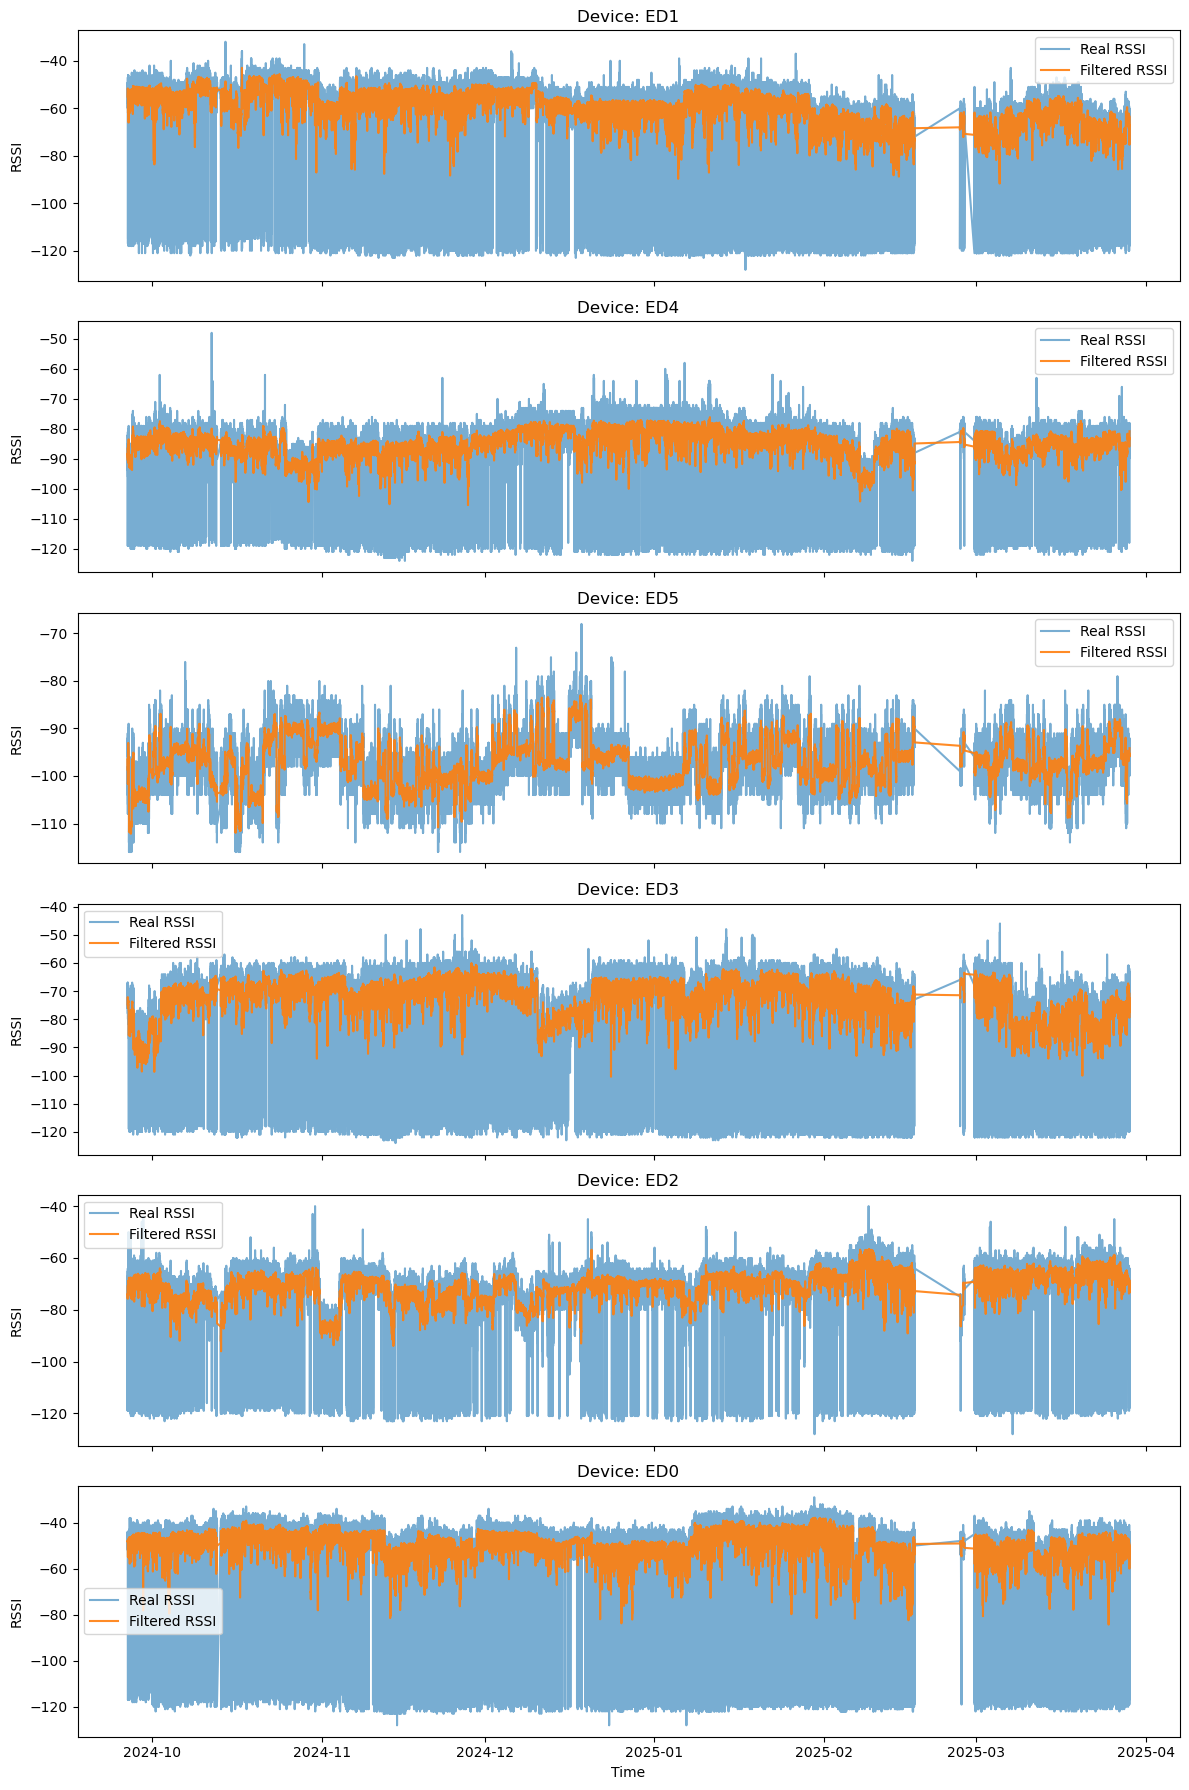

In [6]:
# Plot train data (Real vs. Filtered RSSI) for each device
device_ids = train_df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 3*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = train_df[train_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

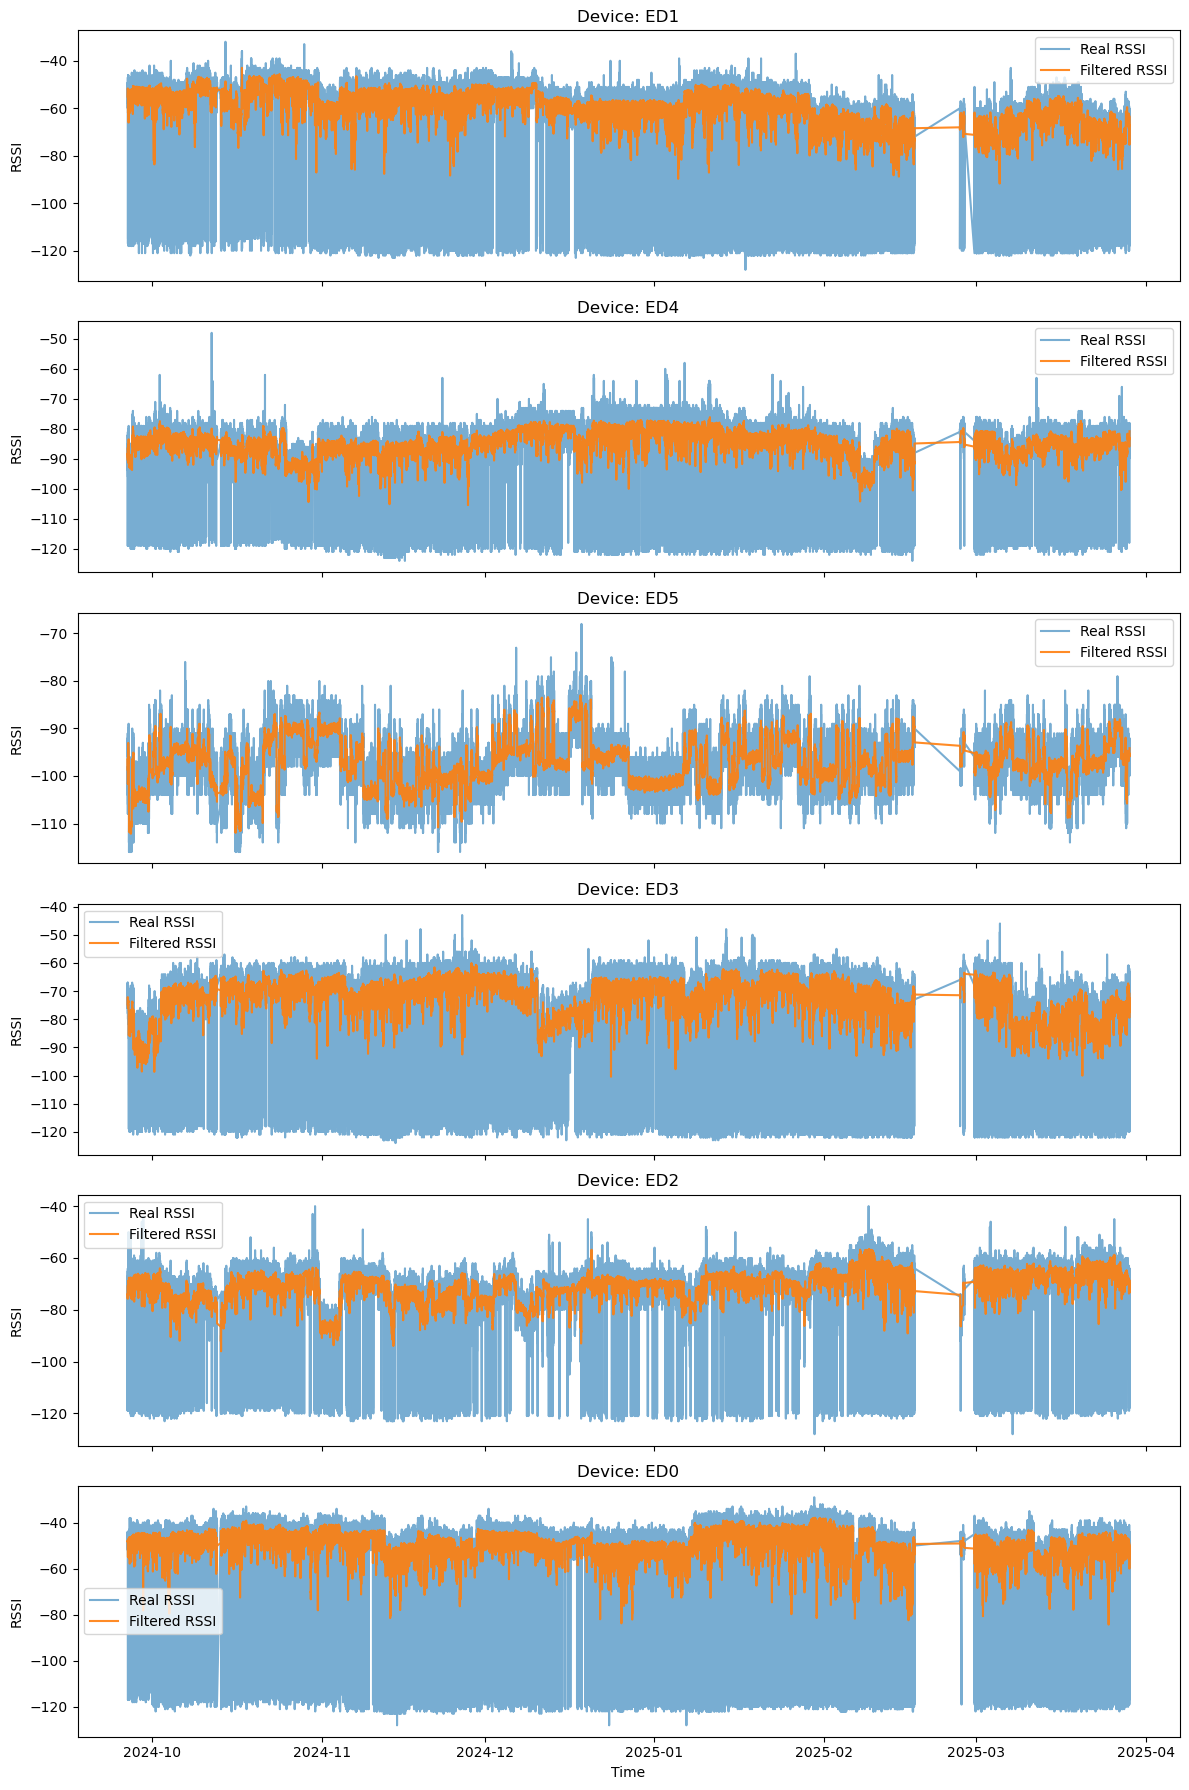

In [7]:
# Plot train data (Real vs. Filtered RSSI) for each device
device_ids = train_df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 3*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = train_df[train_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

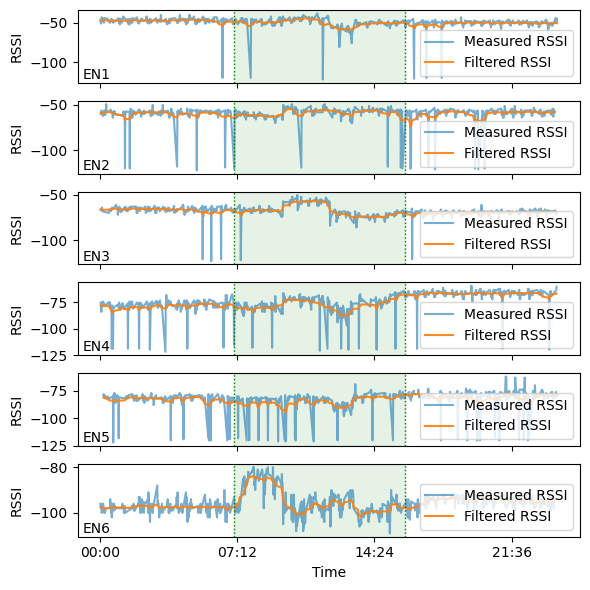

In [8]:
# Ensure 'time' column is in datetime format
train_df['time'] = pd.to_datetime(train_df['time'])

# Define the one-day segment (December 20, 2024)
segment_start = '2024-12-20 00:00:00'
segment_end   = '2024-12-20 23:59:59'
train_df_segment = train_df[
    (train_df['time'] >= segment_start) & 
    (train_df['time'] <= segment_end)
]

# Device mapping: original ID to display name
device_map = {
    'ED0': 'EN1',
    'ED1': 'EN2',
    'ED2': 'EN3',
    'ED3': 'EN4',
    'ED4': 'EN5',
    'ED5': 'EN6'
}

# Get unique device IDs in ascending order
device_ids = sorted(train_df_segment['device_id'].unique())
num_devices = len(device_ids)

# Create subplots for each device
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(6, 1 * num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

# Define the highlight window (9 AM to 4 PM)
highlight_start = pd.to_datetime('2024-12-20 07:00:00')
highlight_end   = pd.to_datetime('2024-12-20 16:00:00')

for ax, device in zip(axes, device_ids):
    device_data = train_df_segment[train_df_segment['device_id'] == device].sort_values('time')
    
    # Plot real vs. filtered RSSI
    ax.plot(device_data['time'], device_data['rssi'], label='Measured RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    
    # Highlight 9 AM to 4 PM with a translucent rectangle
    ax.axvspan(highlight_start, highlight_end, color='green', alpha=0.1)
    # Add dotted lines on the left and right edges of the highlight
    ax.axvline(highlight_start, color='green', linestyle=':', linewidth=1)
    ax.axvline(highlight_end, color='green', linestyle=':', linewidth=1)
    
    # Add device name annotation (bottom left) using our mapping
    device_label = device_map.get(device, device)
    ax.text(0.01, 0.01, device_label, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='left')
    
    ax.set_ylabel('RSSI')
    # Place legend in the bottom right corner
    ax.legend(loc='lower right')
    # Reduce the number of time ticks to 4 for clarity
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    # Optional: format x-axis labels nicely for datetimes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel('Time')
plt.tight_layout(h_pad=0.5)  # Reduced gap between plots

# Save the figure at high resolution
plt.savefig('../all_data_files/Localization/Real_vs_FilteredRSSI_over_shortTime.png', dpi=1000)
plt.show()

# Log-Distance Path Loss & Shadowing Modeling

We adopt the following two models:

1. **LDPLM-MW (Structural Model):**

$$
PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + \sum_{i=1}^{2} W_i\,L_i + \epsilon,
$$

where:
- $PL(d_0)$ is the reference path loss,
- $n$ is the path loss exponent,
- $d$ is the distance,
- $W_1 = c_{walls}$ and $W_2 = w_{walls}$ are the counts of two wall types,
- $L_1 = L_c$ and $L_2 = L_w$ are their corresponding attenuation factors, and
- $\epsilon$ captures random shadowing effects.

2. **LDPLM-MW-EP (Extended Model with Environmental Parameters):**

$$
PL(d) = PL(d_0) + 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + 20\,\log_{10}(f) + \sum_{i=1}^{2} W_i\,L_i + \sum_{j=1}^{5} \theta_j\,E_j + k_{snr}\,snr + \epsilon,
$$

where, in addition to the parameters above:
- $f$ is the frequency,
- $20\,\log_{10}(f)$ accounts for frequency-dependent loss,
- $\{E_j\}_{j=1}^{5}$ are five environmental variables (e.g., CO$_2$, humidity, PM2.5, pressure, temperature) with corresponding coefficients $\{\theta_j\}$,
- $snr$ is the signal-to-noise ratio with coefficient $k_{snr}$.

These models form the basis of our analysis and are implemented as follows.


In [9]:
# Feature Extraction & Model Function Definitions
features = ['distance', 'frequency', 'c_walls', 'w_walls', 'co2', 
            'humidity', 'pm25', 'pressure', 'temperature', 'snr']
X_train = np.column_stack([train_df[feat].values for feat in features])
X_test  = np.column_stack([test_df[feat].values for feat in features])

# Targets: raw and filtered exp_pl
y_train_raw  = train_df['exp_pl'].values
y_test_raw   = test_df['exp_pl'].values
y_train_filt = train_df['exp_pl_filtered'].values
y_test_filt  = test_df['exp_pl_filtered'].values

# LDPLM-MW: using distance, c_walls, w_walls (indices 0,2,3)
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1
    return PL_d0 + 10 * n * np.log10(d/d0) + c_walls * L_c + w_walls * L_w

# LDPLM-MW-EP: using all 10 features
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, freq, c_walls, w_walls, co2, hum, pm25, pres, temp, snr = x
    d0 = 1
    return (PL_d0 + 10 * n * np.log10(d/d0) + 20*np.log10(freq) +
            c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * hum + a_pm25 * pm25 +
            a_pres * pres + a_temp * temp + snr * k_snr)

idx_mw = [0, 2, 3]
idx_ep = list(range(10))

### Model Fitting & Evaluation (Raw and Filtered)

In [10]:
# Initial guesses
initial_guess_mw = [30, 2, 5, 3]
initial_guess_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]

# --- Fit on Raw exp_pl ---
popt_mw_raw, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_raw, p0=initial_guess_mw, maxfev=100000)
popt_ep_raw, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_raw, p0=initial_guess_ep, maxfev=100000)

# --- Fit on Filtered exp_pl ---
popt_mw_filt, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_filt, p0=initial_guess_mw, maxfev=100000)
popt_ep_filt, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_filt, p0=initial_guess_ep, maxfev=100000)

# --- Predictions ---
# Raw models
y_pred_mw_raw   = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_raw)
y_pred_ep_raw   = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_raw)
y_train_pred_mw_raw = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_raw)
y_train_pred_ep_raw = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_raw)
# Filtered models
y_pred_mw_filt  = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_filt)
y_pred_ep_filt  = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_filt)
y_train_pred_mw_filt = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_filt)
y_train_pred_ep_filt = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_filt)

# --- Shadowing (train) & Metrics ---
shadowing_mw_raw  = y_train_raw - y_train_pred_mw_raw
sigma_mw_raw      = np.std(shadowing_mw_raw)
shadowing_ep_raw  = y_train_raw - y_train_pred_ep_raw
sigma_ep_raw      = np.std(shadowing_ep_raw)
shadowing_mw_filt = y_train_filt - y_train_pred_mw_filt
sigma_mw_filt     = np.std(shadowing_mw_filt)
shadowing_ep_filt = y_train_filt - y_train_pred_ep_filt
sigma_ep_filt     = np.std(shadowing_ep_filt)

# Test metrics
rmse_mw_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_mw_raw))
r2_mw_raw_test    = r2_score(y_test_raw, y_pred_mw_raw)
rmse_ep_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_ep_raw))
r2_ep_raw_test    = r2_score(y_test_raw, y_pred_ep_raw)
rmse_mw_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_mw_filt))
r2_mw_filt_test   = r2_score(y_test_filt, y_pred_mw_filt)
rmse_ep_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_ep_filt))
r2_ep_filt_test   = r2_score(y_test_filt, y_pred_ep_filt)

# Train metrics
rmse_mw_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_mw_raw))
r2_mw_raw_train    = r2_score(y_train_raw, y_train_pred_mw_raw)
rmse_ep_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_ep_raw))
r2_ep_raw_train    = r2_score(y_train_raw, y_train_pred_ep_raw)
rmse_mw_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_mw_filt))
r2_mw_filt_train   = r2_score(y_train_filt, y_train_pred_mw_filt)
rmse_ep_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_ep_filt))
r2_ep_filt_train   = r2_score(y_train_filt, y_train_pred_ep_filt)

### Parameter & Metrics Comparison

In [11]:
# Parameters from curve fitting
params_mw_raw  = {'PL(d0)': popt_mw_raw[0], 'n': popt_mw_raw[1], 'L_c': popt_mw_raw[2], 'L_w': popt_mw_raw[3]}
params_ep_raw  = {'PL(d0)': popt_ep_raw[0], 'n': popt_ep_raw[1], 'L_c': popt_ep_raw[2], 'L_w': popt_ep_raw[3],
                  'a_co2': popt_ep_raw[4], 'a_hum': popt_ep_raw[5], 'a_pm25': popt_ep_raw[6],
                  'a_pres': popt_ep_raw[7], 'a_temp': popt_ep_raw[8], 'k_snr': popt_ep_raw[9]}
params_mw_filt = {'PL(d0)': popt_mw_filt[0], 'n': popt_mw_filt[1], 'L_c': popt_mw_filt[2], 'L_w': popt_mw_filt[3]}
params_ep_filt = {'PL(d0)': popt_ep_filt[0], 'n': popt_ep_filt[1], 'L_c': popt_ep_filt[2], 'L_w': popt_ep_filt[3],
                  'a_co2': popt_ep_filt[4], 'a_hum': popt_ep_filt[5], 'a_pm25': popt_ep_filt[6],
                  'a_pres': popt_ep_filt[7], 'a_temp': popt_ep_filt[8], 'k_snr': popt_ep_filt[9]}

# Build table of parameters for all 4 models
shared_params = ['PL(d0)', 'n', 'L_c', 'L_w']
unique_params = ['a_co2', 'a_hum', 'a_pm25', 'a_pres', 'a_temp', 'k_snr']
parameter_list = shared_params + unique_params

ldplm_mw_raw_vals  = [params_mw_raw.get(p, '-') for p in parameter_list]
ldplm_ep_raw_vals  = [params_ep_raw.get(p, '-') for p in parameter_list]
ldplm_mw_filt_vals = [params_mw_filt.get(p, '-') for p in parameter_list]
ldplm_ep_filt_vals = [params_ep_filt.get(p, '-') for p in parameter_list]

params_comp_df = pd.DataFrame({
    'LDPLM-MW (raw)': ldplm_mw_raw_vals,
    'LDPLM-MW (filt)': ldplm_mw_filt_vals,
    'LDPLM-MW-EP (raw)': ldplm_ep_raw_vals,
    'LDPLM-MW-EP (filt)': ldplm_ep_filt_vals
}, index=parameter_list)

# Build Metrics DataFrame
metrics = ['RMSE (Train)', 'RMSE (Test)', 'R2 (Train)', 'R2 (Test)', 'σ (dB)']
metrics_values = {
    'LDPLM-MW (raw)': [rmse_mw_raw_train, rmse_mw_raw_test, r2_mw_raw_train, r2_mw_raw_test, sigma_mw_raw],
    'LDPLM-MW (filt)': [rmse_mw_filt_train, rmse_mw_filt_test, r2_mw_filt_train, r2_mw_filt_test, sigma_mw_filt],
    'LDPLM-MW-EP (raw)': [rmse_ep_raw_train, rmse_ep_raw_test, r2_ep_raw_train, r2_ep_raw_test, sigma_ep_raw],
    'LDPLM-MW-EP (filt)': [rmse_ep_filt_train, rmse_ep_filt_test, r2_ep_filt_train, r2_ep_filt_test, sigma_ep_filt]
}
metrics_df = pd.DataFrame(metrics_values, index=metrics)

# Output the two tables
print("\n=== Table of Parameters to be Compared ===\n")
display(params_comp_df)

print("\n=== Performance Metrics ===\n")
display(metrics_df)


=== Table of Parameters to be Compared ===



,LDPLM-MW (raw),LDPLM-MW (filt),LDPLM-MW-EP (raw),LDPLM-MW-EP (filt)
PL(d0),32.257108,32.257113,8.037496,-10.853073
n,3.577826,3.577825,3.144023,3.500321
L_c,9.63667,9.636672,8.370556,9.522809
L_w,2.641741,2.641742,3.026764,2.685096
a_co2,-,-,-0.002437,-0.003607
a_hum,-,-,-0.069493,-0.116426
a_pm25,-,-,-0.087865,-0.065453
a_pres,-,-,-0.015675,-0.008635
a_temp,-,-,-0.004216,-0.086382
k_snr,-,-,-2.076106,-0.375209



=== Performance Metrics ===



,LDPLM-MW (raw),LDPLM-MW (filt),LDPLM-MW-EP (raw),LDPLM-MW-EP (filt)
RMSE (Train),11.504175,5.799441,8.166910,5.530222
RMSE (Test),11.358924,5.627182,8.100571,5.379637
R2 (Train),0.650471,0.879850,0.823848,0.890746
R2 (Test),0.658426,0.887062,0.826283,0.896780
σ (dB),11.504175,5.799441,8.166910,5.530222


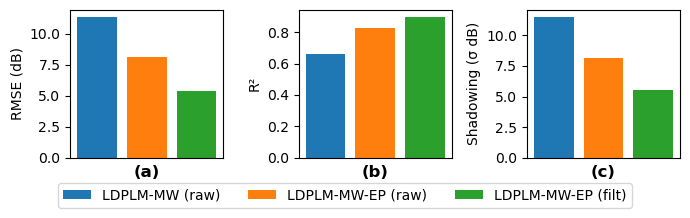

In [12]:
# Subset of models we want to compare
model_subset = ['LDPLM-MW (raw)', 'LDPLM-MW-EP (raw)', 'LDPLM-MW-EP (filt)']

# Extract the relevant test metrics from your metrics_df
rmse_test_values = metrics_df.loc['RMSE (Test)', model_subset]
r2_test_values   = metrics_df.loc['R2 (Test)',   model_subset]
sigma_values     = metrics_df.loc['σ (dB)',      model_subset]  # Shadowing

# Create figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))

# Define a color scheme for the three bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# ----------------------
# (a) RMSE(Test)
# ----------------------
bars_a = axs[0].bar(model_subset, rmse_test_values, color=colors)
# axs[0].set_title('RMSE (Test)')
axs[0].set_ylabel('RMSE (dB)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0].text(0.5, -0.05, '(a)', transform=axs[0].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')
# Label each bar in subplot (a) for the legend
for bar, label in zip(bars_a, model_subset):
    bar.set_label(label)

# ----------------------
# (b) R2(Test)
# ----------------------
axs[1].bar(model_subset, r2_test_values, color=colors)
# axs[1].set_title('R² (Test)')
axs[1].set_ylabel('R²')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)
axs[1].text(0.5, -0.05, '(b)', transform=axs[1].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')

# ----------------------
# (c) Shadowing (σ dB)
# ----------------------
axs[2].bar(model_subset, sigma_values, color=colors)
# axs[2].set_title('Shadowing (σ dB)')
axs[2].set_ylabel('Shadowing (σ dB)')
axs[2].tick_params(axis='x', bottom=False, labelbottom=False)
axs[2].text(0.5, -0.05, '(c)', transform=axs[2].transAxes,
            fontsize=12, fontweight='bold', ha='center', va='top')

# Create one combined legend below the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.10), ncol=3)

# Adjust layout to reduce the white gap at the bottom
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()

# Save the figure at high resolution
plt.savefig('../all_data_files/Localization/rmse_r2_comparison.png', dpi=2000, bbox_inches='tight')
plt.show()

### Combined Plots (Raw & Filtered) and Residual Distribution Table

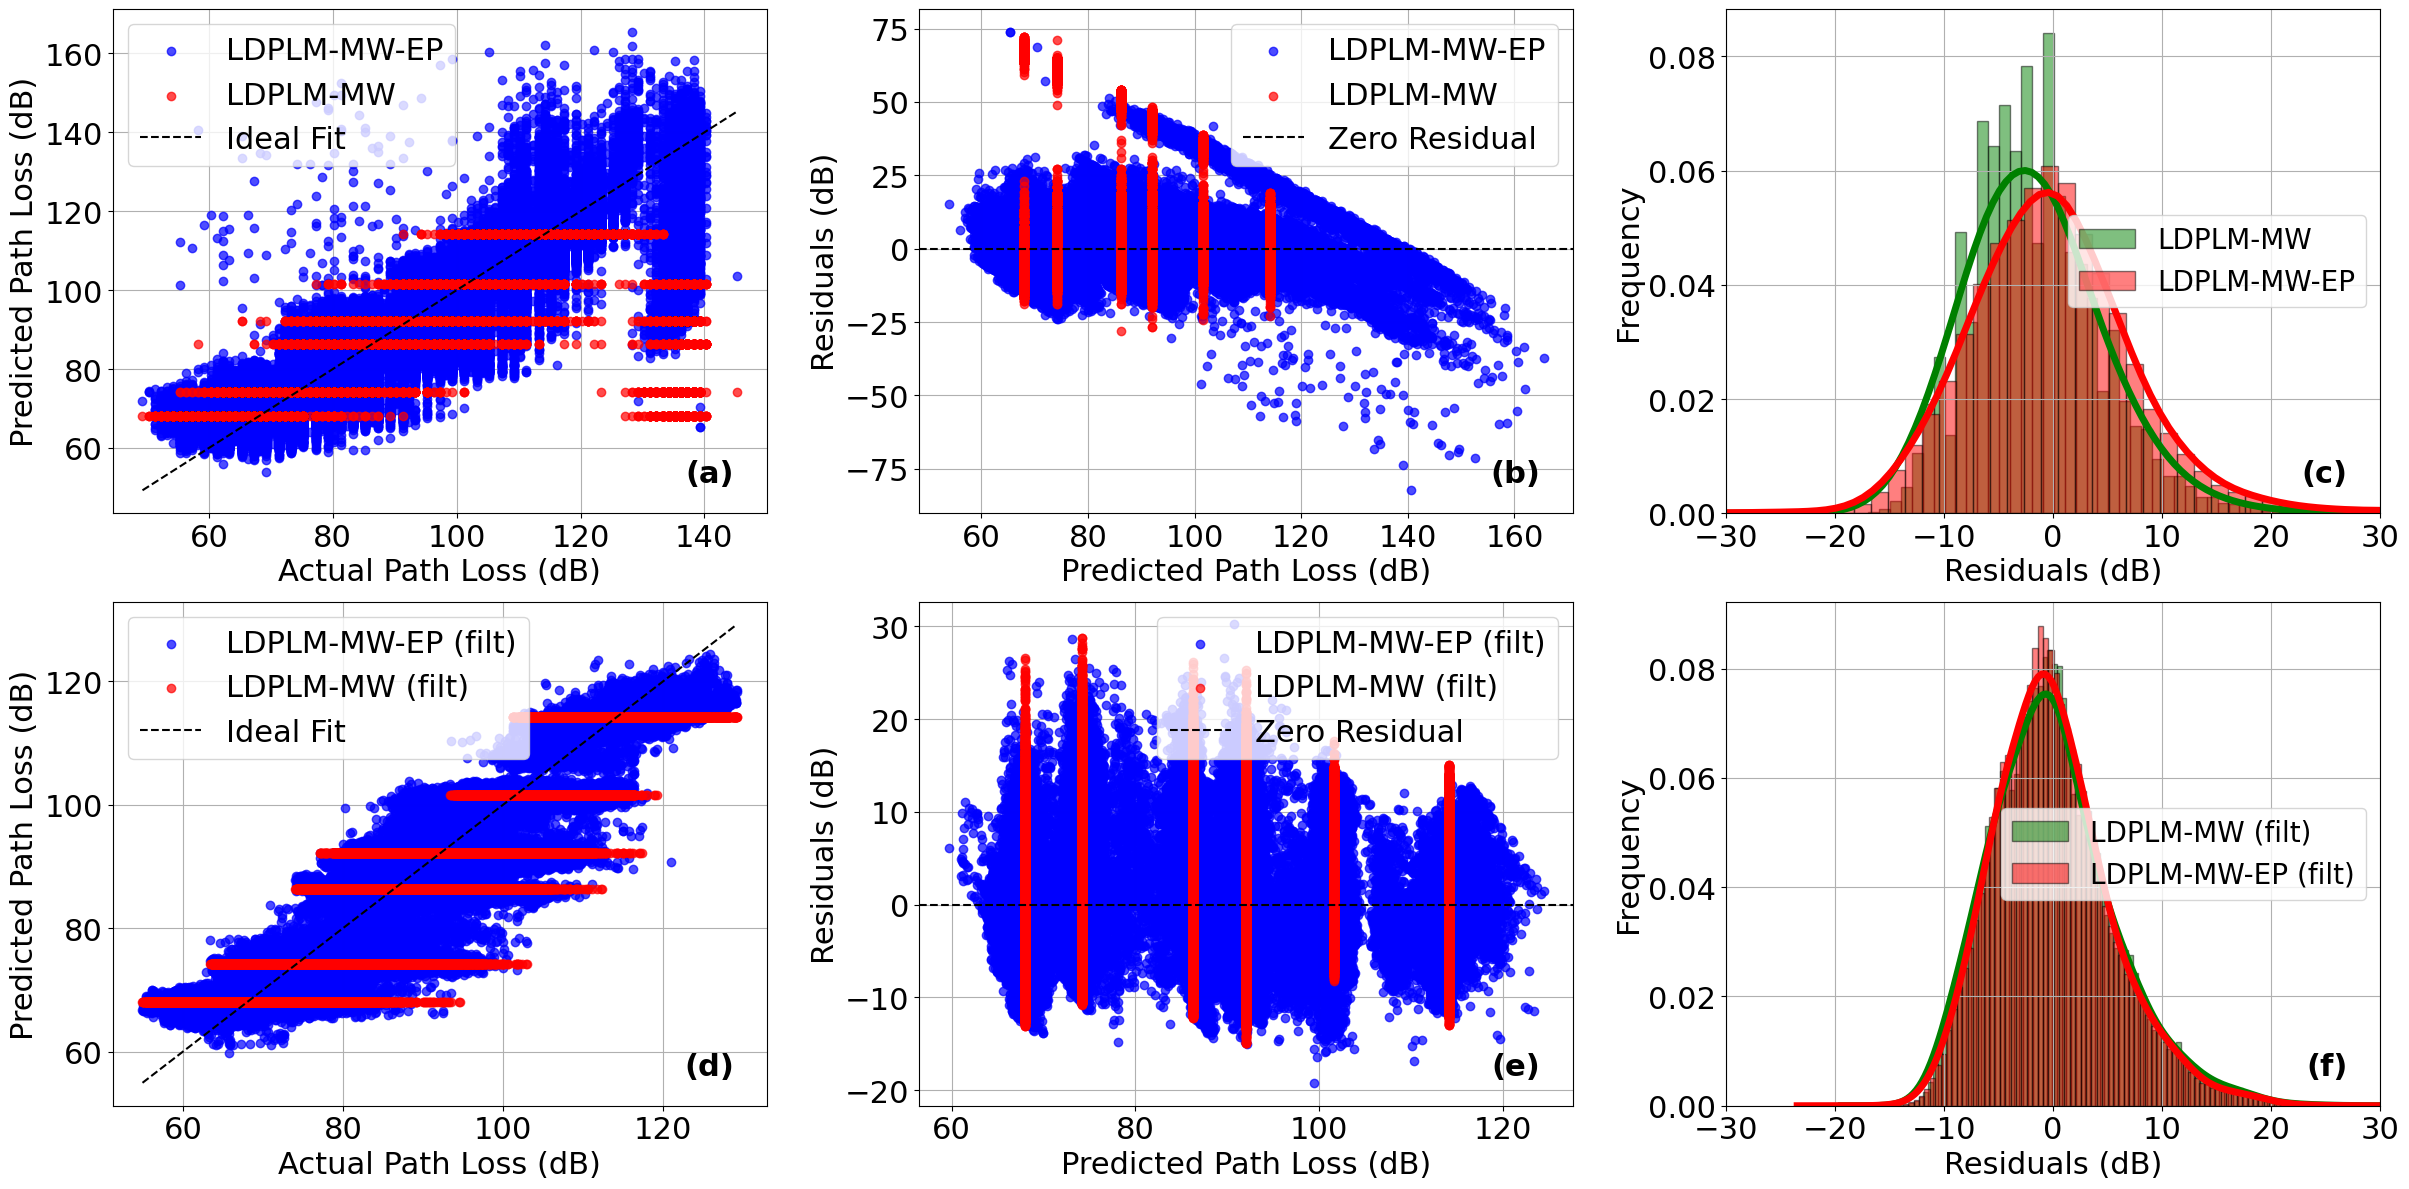


Residual Distribution Values:


,Mean (dB),Skewness
LDPLM-MW (raw),-0.042911,3.575299
LDPLM-MW (filt),-0.042923,0.648821
LDPLM-MW-EP (raw),-0.016254,0.915838
LDPLM-MW-EP (filt),-0.037488,0.641611


In [13]:
# Compute test residuals for raw and filtered models
residuals_mw_test = y_test_raw - y_pred_mw_raw
residuals_ep_test = y_test_raw - y_pred_ep_raw
residuals_mw_test_filt = y_test_filt - y_pred_mw_filt
residuals_ep_test_filt = y_test_filt - y_pred_ep_filt

# Define plotting targets/predictions (raw & filtered)
PL_test_mw = y_test_raw        # Raw target for MW & EP (identical)
PL_test_ep = y_test_raw
PL_pred_mw = y_pred_mw_raw     # Raw predictions
PL_pred_ep = y_pred_ep_raw

PL_test_mw_filt = y_test_filt  # Filtered targets for MW & EP (identical)
PL_test_ep_filt = y_test_filt
PL_pred_mw_filt = y_pred_mw_filt  # Filtered predictions
PL_pred_ep_filt = y_pred_ep_filt

# Define ideal fit line boundaries
min_PL = min(PL_test_ep.min(), PL_test_mw.min())
max_PL = max(PL_test_ep.max(), PL_test_mw.max())
min_PL_filt = min(PL_test_ep_filt.min(), PL_test_mw_filt.min())
max_PL_filt = max(PL_test_ep_filt.max(), PL_test_mw_filt.max())

# Create a figure with 2 rows x 3 columns (Row 1: Raw, Row 2: Filtered)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# -------------------- Row 1: Raw Models --------------------
# (a) Actual vs Predicted Path Loss
ax = axes[0, 0]
ax.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
ax.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
ax.plot([min_PL, max_PL], [min_PL, max_PL], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(a)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (b) Residuals vs Predicted Path Loss
ax = axes[0, 1]
ax.scatter(PL_pred_ep, residuals_ep_test, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
ax.scatter(PL_pred_mw, residuals_mw_test, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(b)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (c) Histogram & KDE of Residuals
ax = axes[0, 2]
ax.hist(residuals_mw_test, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(c)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# -------------------- Row 2: Filtered Models --------------------
# (d) Actual vs Predicted Path Loss (Filtered)
ax = axes[1, 0]
ax.scatter(PL_test_ep_filt, PL_pred_ep_filt, alpha=0.7, label='LDPLM-MW-EP (filt)', color='blue', zorder=2)
ax.scatter(PL_test_mw_filt, PL_pred_mw_filt, alpha=0.7, label='LDPLM-MW (filt)', color='red', zorder=3)
ax.plot([min_PL_filt, max_PL_filt], [min_PL_filt, max_PL_filt], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(d)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (e) Residuals vs Predicted Path Loss (Filtered)
ax = axes[1, 1]
ax.scatter(PL_pred_ep_filt, residuals_ep_test_filt, alpha=0.7, label='LDPLM-MW-EP (filt)', color='blue', zorder=2)
ax.scatter(PL_pred_mw_filt, residuals_mw_test_filt, alpha=0.7, label='LDPLM-MW (filt)', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(e)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (f) Histogram & KDE of Residuals (Filtered)
ax = axes[1, 2]
ax.hist(residuals_mw_test_filt, bins=100, alpha=0.5, label='LDPLM-MW (filt)', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test_filt, bins=100, alpha=0.5, label='LDPLM-MW-EP (filt)', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test_filt, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test_filt, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(f)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

plt.tight_layout()
plt.savefig('../all_data_files/All_Plots_as_Subplots_Kalman.png', dpi=1000)
plt.show()

# -------------------- Residual Distribution Table (Test Data) --------------------
resid_mean_mw      = round(np.mean(residuals_mw_test), 6)
resid_skew_mw      = round(pd.Series(residuals_mw_test).skew(), 6)
resid_mean_ep      = round(np.mean(residuals_ep_test), 6)
resid_skew_ep      = round(pd.Series(residuals_ep_test).skew(), 6)
resid_mean_mw_filt = round(np.mean(residuals_mw_test_filt), 6)
resid_skew_mw_filt = round(pd.Series(residuals_mw_test_filt).skew(), 6)
resid_mean_ep_filt = round(np.mean(residuals_ep_test_filt), 6)
resid_skew_ep_filt = round(pd.Series(residuals_ep_test_filt).skew(), 6)

resid_df = pd.DataFrame({
    'Mean (dB)': [resid_mean_mw, resid_mean_mw_filt, resid_mean_ep, resid_mean_ep_filt],
    'Skewness': [resid_skew_mw, resid_skew_mw_filt, resid_skew_ep, resid_skew_ep_filt]
}, index=['LDPLM-MW (raw)', 'LDPLM-MW (filt)', 'LDPLM-MW-EP (raw)', 'LDPLM-MW-EP (filt)'])

print("\nResidual Distribution Values:")
display(resid_df)

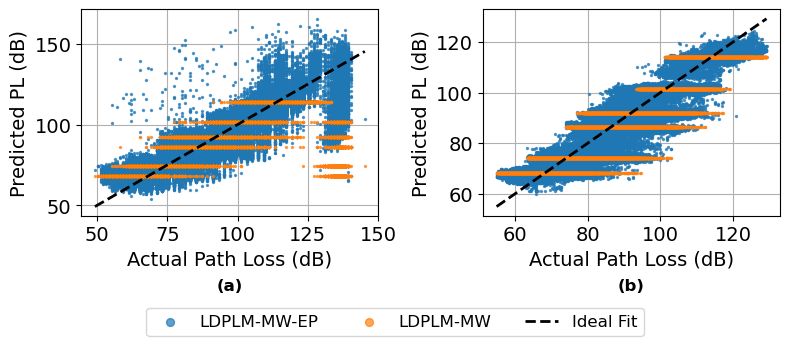

In [14]:
# 1) Create a figure with 1 row x 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

# ----------------------
# (a) Raw Models - Labeled
# ----------------------
ax_left = axs[0]
ax_left.scatter(PL_test_ep, PL_pred_ep, s=2, alpha=0.7, label='LDPLM-MW-EP', color='#1f77b4', zorder=2)
ax_left.scatter(PL_test_mw, PL_pred_mw, s=2, alpha=0.7, label='LDPLM-MW', color='#ff7f0e', zorder=3)
ax_left.plot([min_PL, max_PL], [min_PL, max_PL], 'k--', linewidth=2, label='Ideal Fit', zorder=4)
ax_left.set_xlabel('Actual Path Loss (dB)', fontsize=14)
ax_left.set_ylabel('Predicted PL (dB)', fontsize=14)
ax_left.grid(True)
ax_left.tick_params(axis='both', which='major', labelsize=14)
ax_left.text(0.5, -0.3, '(a)', transform=ax_left.transAxes,
             fontsize=12, fontweight='bold', ha='center', va='top')

# ----------------------
# (b) Filtered Models - No Legend Labels
# ----------------------
ax_right = axs[1]
ax_right.scatter(PL_test_ep_filt, PL_pred_ep_filt, s=2, alpha=0.7, label='_nolegend_', color='#1f77b4', zorder=2)
ax_right.scatter(PL_test_mw_filt, PL_pred_mw_filt, s=2, alpha=0.7, label='_nolegend_', color='#ff7f0e', zorder=3)
ax_right.plot([min_PL_filt, max_PL_filt], [min_PL_filt, max_PL_filt], 'k--', linewidth=2, label='_nolegend_', zorder=4)
ax_right.set_xlabel('Actual Path Loss (dB)', fontsize=14)
ax_right.set_ylabel('Predicted PL (dB)', fontsize=14)
ax_right.grid(True)
ax_right.tick_params(axis='both', which='major', labelsize=14)
ax_right.text(0.5, -0.3, '(b)', transform=ax_right.transAxes,
              fontsize=12, fontweight='bold', ha='center', va='top')

# 2) Collect handles/labels from both subplots
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
all_handles = handles_left + handles_right
all_labels = labels_left + labels_right

# 3) Create a single combined legend below the subplots
fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=3, fontsize=12, markerscale=4)

# 4) Final layout & save
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('../all_data_files/Localization/Kalman_vs_Raw_Residuals.png', dpi=2000, bbox_inches='tight')
plt.show()

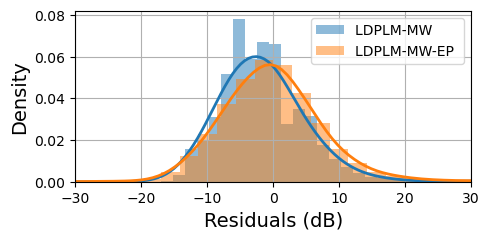

In [38]:
plt.figure(figsize=(5, 2.5))
# Plot histograms for residuals with density normalization
plt.hist(residuals_mw_test, bins=55, alpha=0.5, label='LDPLM-MW ', color='#1f77b4', density=True)
plt.hist(residuals_ep_test, bins=55, alpha=0.5, label='LDPLM-MW-EP ', color='#ff7f0e', density=True)
# Plot KDE curves for both residual distributions
sns.kdeplot(residuals_mw_test, color='#1f77b4', bw_adjust=3, linewidth=2)
sns.kdeplot(residuals_ep_test, color='#ff7f0e', bw_adjust=3, linewidth=2)
# Set labels, title, and x-axis limits
plt.xlabel('Residuals (dB)', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title('Residual Distribution (Raw Models)', fontsize=18)
plt.xlim(-30, 30)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('../all_data_files/Localization/residuals.png', dpi=1000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: center;">
 Distance Estimation for Localization
</p>

### Distance Estimation: The Base Equations

To estimate the distance $d$, we invert our main path loss models. This provides a direct means to compute the distance from the observed path loss values. The derivations are kept succinct to maintain clarity.

**Model A (LDPLM-MW):**

<div style="font-size: 150%;">
$$
d = 10^{\frac{PL - PL(d_0) - \left(W_c L_c + W_w L_w\right)}{10\,n}},
$$

</div>

**Model B (LDPLM-MW-EP):**

<div style="font-size: 150%;">

$$
d = 10^{\frac{PL - PL(d_0) - 20\,\log_{10}(f) - \left(W_c L_c + W_w L_w\right) - \sum_{j=1}^{5} \theta_j\,E_j - k_{snr}\,snr}{10\,n}}.
$$
</div>




These inverted equations allow us to compute the distance from the measured path loss while accounting for both structural losses (from walls) and environmental factors.


In [16]:
# ----------------------------
# Define Distance Inversion Functions for distance estimation
# ----------------------------
def estimate_distance_modelA(PL, PL_d0, n, L_c, L_w, W_c, W_w):
    # LDPLM-MW: Model A
    # PL = PL(d0) + 10*n*log10(d) + (W_c*L_c + W_w*L_w) + ε
    return 10 ** ((PL - PL_d0 - (W_c * L_c + W_w * L_w)) / (10 * n))

def estimate_distance_modelB(PL, PL_d0, n, L_c, L_w, f, theta_E, E_matrix, k_snr, SNR, W_c, W_w):
    # LDPLM-MW-EP: Model B
    # PL = PL(d0) + 10*n*log10(d) + 20*log10(f) + (W_c*L_c + W_w*L_w)
    #      + (θ1*E1 + ... + θ5*E5) + k_SNR*SNR + ε
    env_term = np.dot(theta_E, E_matrix)  # E_matrix shape: (5, number_of_samples)
    return 10 ** ((PL - PL_d0 - 20*np.log10(f) - (W_c * L_c + W_w * L_w) - env_term - k_snr * SNR) / (10 * n))

# ------------------------------------------------------------
# Prepare Environmental Data; particularly for Model B
# ------------------------------------------------------------
E_matrix_test = np.array([
    test_df['co2'].values,
    test_df['humidity'].values,
    test_df['pm25'].values,
    test_df['pressure'].values,
    test_df['temperature'].values
])
f_test   = test_df['frequency'].values
W_c_test = test_df['c_walls'].values
W_w_test = test_df['w_walls'].values
SNR_test = test_df['snr'].values

# ----------------------------
# Compute Distance Estimates (using full PL)
# ----------------------------
# Model A (LDPLM-MW)
d_A_raw = estimate_distance_modelA(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_mw_raw[0],
    n = popt_mw_raw[1],
    L_c = popt_mw_raw[2],
    L_w = popt_mw_raw[3],
    W_c = W_c_test,
    W_w = W_w_test
)
d_A_filt = estimate_distance_modelA(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_mw_filt[0],
    n = popt_mw_filt[1],
    L_c = popt_mw_filt[2],
    L_w = popt_mw_filt[3],
    W_c = W_c_test,
    W_w = W_w_test
)

# Model B (LDPLM-MW-EP)
theta_E_raw  = popt_ep_raw[4:9]
theta_E_filt = popt_ep_filt[4:9]

d_B_raw = estimate_distance_modelB(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_ep_raw[0],
    n = popt_ep_raw[1],
    L_c = popt_ep_raw[2],
    L_w = popt_ep_raw[3],
    f = f_test,
    theta_E = theta_E_raw,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_raw[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)
d_B_filt = estimate_distance_modelB(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_ep_filt[0],
    n = popt_ep_filt[1],
    L_c = popt_ep_filt[2],
    L_w = popt_ep_filt[3],
    f = f_test,
    theta_E = theta_E_filt,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_filt[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)

### Analysis Metrics for Comparison

In [17]:
# ------------------------------------------------
# Compute Metrics for Model Comaprison
# ------------------------------------------------
def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2

true_distance = test_df['distance'].values

metrics_neglected = {
    'Model A Raw': compute_metrics(true_distance, d_A_raw),
    'Model A Filt': compute_metrics(true_distance, d_A_filt),
    'Model B Raw': compute_metrics(true_distance, d_B_raw),
    'Model B Filt': compute_metrics(true_distance, d_B_filt)
}

metrics_df_neglected = pd.DataFrame(metrics_neglected, index=['MAE', 'RMSE', 'R²'])
print("\n=== Distance Estimation Metrics ===\n")
display(metrics_df_neglected)


=== Distance Estimation Metrics ===



,Model A Raw,Model A Filt,Model B Raw,Model B Filt
MAE,21.290737,6.256315,10.861737,6.090325
RMSE,89.794322,9.483118,22.521639,9.249517
R²,-52.337081,0.405114,-2.355301,0.434061


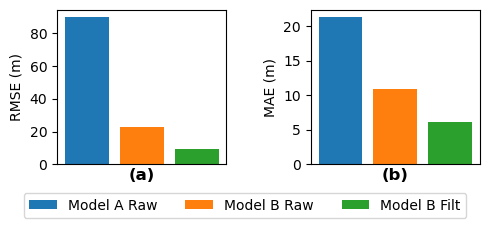

In [18]:
# Define the subset of models to compare
model_subset = ['Model A Raw', 'Model B Raw', 'Model B Filt']

# Extract RMSE and MAE values from your metrics dataframe
rmse_values = metrics_df_neglected.loc['RMSE', model_subset]
mae_values  = metrics_df_neglected.loc['MAE', model_subset]

# Create subplots for RMSE and MAE
fig, axs = plt.subplots(1, 2, figsize=(5, 2))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# (a) RMSE plot
bars_a = axs[0].bar(model_subset, rmse_values, color=colors)
axs[0].set_ylabel('RMSE (m)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0].text(0.5, -0.1, '(a)', transform=axs[0].transAxes,
            fontsize=12, fontweight='bold', ha='center')
# Label each bar for the common legend
for bar, label in zip(bars_a, model_subset):
    bar.set_label(label)

# (b) MAE plot
axs[1].bar(model_subset, mae_values, color=colors)
axs[1].set_ylabel('MAE (m)')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)
axs[1].text(0.5, -0.1, '(b)', transform=axs[1].transAxes,
            fontsize=12, fontweight='bold', ha='center')

# Create a common legend below the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.savefig('../all_data_files/Localization/distance_rmse_mae_comparison.png', dpi=1000, bbox_inches='tight')
plt.show()

In [19]:
# ----------------------------------------------------
# Compute absolute errors and CDF for both models
# ----------------------------------------------------

def compute_cdf(errors, bins=100):
    hist_vals, bin_edges = np.histogram(errors, bins=bins, density=True)
    cdf_vals = np.cumsum(hist_vals * np.diff(bin_edges))
    return bin_edges[1:], cdf_vals

error_A_raw  = np.abs(true_distance - d_A_raw)
error_A_filt = np.abs(true_distance - d_A_filt)
error_B_raw  = np.abs(true_distance - d_B_raw)
error_B_filt = np.abs(true_distance - d_B_filt)

x_A_raw,  cdf_A_raw  = compute_cdf(error_A_raw)
x_A_filt, cdf_A_filt = compute_cdf(error_A_filt)
x_B_raw,  cdf_B_raw  = compute_cdf(error_B_raw)
x_B_filt, cdf_B_filt = compute_cdf(error_B_filt)

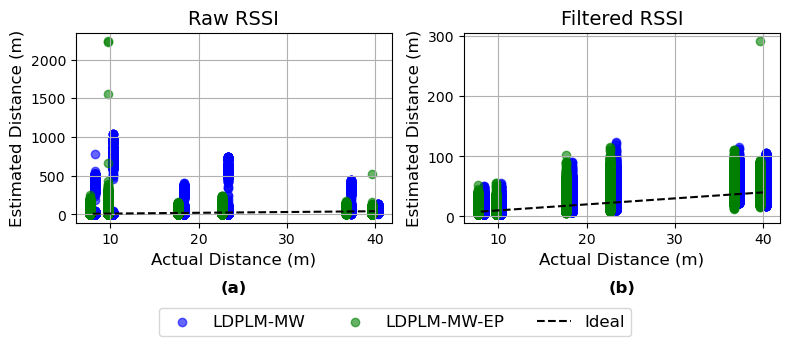

In [20]:
# -------------------------------------------------------
# Scatter Plots (2x1 for estimated vs actual distance)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Define a jitter value for visual separation
jitter = 0.3

def plot_scatter(ax, actual, pred_A, pred_B, title):
    # Add jitter to actual distances for Model A and Model B
    ax.scatter(actual + jitter, pred_A, alpha=0.6, label='LDPLM-MW', color='blue')
    ax.scatter(actual - jitter, pred_B, alpha=0.6, label='LDPLM-MW-EP', color='green')
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', label='Ideal')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Estimated Distance (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot scatter for Raw RSSI and Filtered RSSI
plot_scatter(axes[0], true_distance, d_A_raw, d_B_raw, 'Raw RSSI')
plot_scatter(axes[1], true_distance, d_A_filt, d_B_filt, 'Filtered RSSI')

# Add subplot labels (a) and (b) below each subplot
axes[0].text(0.5, -0.3, '(a)', transform=axes[0].transAxes,
             fontsize=12, fontweight='bold', ha='center', va='top')
axes[1].text(0.5, -0.3, '(b)', transform=axes[1].transAxes,
             fontsize=12, fontweight='bold', ha='center', va='top')

# Collect handles/labels from both subplots
handles_a, labels_a = axes[0].get_legend_handles_labels()
handles_b, labels_b = axes[1].get_legend_handles_labels()
all_handles = handles_a + handles_b
all_labels = labels_a + labels_b

# Remove duplicate legend entries while preserving order
seen = {}
unique_handles = []
unique_labels = []
for h, lbl in zip(all_handles, all_labels):
    if lbl not in seen:
        unique_handles.append(h)
        unique_labels.append(lbl)
        seen[lbl] = True

# Create a single combined legend below the subplots
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=3, fontsize=12)

# Adjust layout to include legend space and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('../all_data_files/Localization/distance_scatter.png', dpi=1000, bbox_inches='tight')
plt.show()

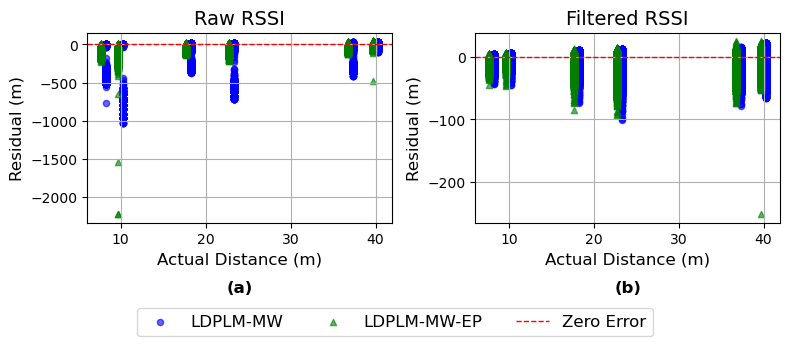

In [21]:
# Create subplots (1 row, 2 columns) for residuals vs actual distance
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Compute residuals for Raw and Filtered RSSI
resid_A_raw  = true_distance - d_A_raw
resid_B_raw  = true_distance - d_B_raw
resid_A_filt = true_distance - d_A_filt
resid_B_filt = true_distance - d_B_filt

# Define function to plot residuals with jitter
def plot_residuals(ax, actual, resid_A, resid_B, title, jitter=0.3):
    # Add jitter to actual distances for Model A and Model B residuals
    ax.scatter(actual + jitter, resid_A, alpha=0.6, s=20, color='blue', marker='o', label='LDPLM-MW')
    ax.scatter(actual - jitter, resid_B, alpha=0.6, s=20, color='green', marker='^', label='LDPLM-MW-EP')
    ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Error')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Residual (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot residuals for Raw and Filtered RSSI
plot_residuals(axes[0], true_distance, resid_A_raw, resid_B_raw, 'Raw RSSI')
plot_residuals(axes[1], true_distance, resid_A_filt, resid_B_filt, 'Filtered RSSI')

# Add subplot labels (a) and (b) below each subplot
axes[0].text(0.5, -0.3, '(a)', transform=axes[0].transAxes,
             fontsize=12, fontweight='bold', ha='center', va='top')
axes[1].text(0.5, -0.3, '(b)', transform=axes[1].transAxes,
             fontsize=12, fontweight='bold', ha='center', va='top')

# Collect handles and labels from both subplots
handles_a, labels_a = axes[0].get_legend_handles_labels()
handles_b, labels_b = axes[1].get_legend_handles_labels()
all_handles = handles_a + handles_b
all_labels = labels_a + labels_b

# Remove duplicate legend entries while preserving order
seen = {}
unique_handles = []
unique_labels = []
for h, lbl in zip(all_handles, all_labels):
    if lbl not in seen:
        unique_handles.append(h)
        unique_labels.append(lbl)
        seen[lbl] = True

# Create a single combined legend below the subplots
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=3, fontsize=12)

# Adjust layout to include space for the legend
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

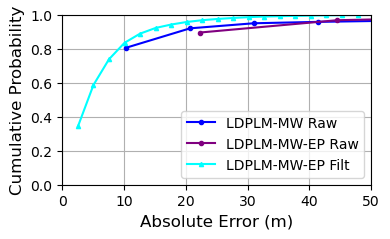

In [22]:
# ----------------------------
# CDF Plots (1x1 for CDF of mean absolute errors)
# ----------------------------
plt.figure(figsize=(4, 2.5))

plt.plot(x_A_raw,  cdf_A_raw,  label='LDPLM-MW Raw',  color='blue',   marker='o', markersize=3)
#plt.plot(x_A_filt, cdf_A_filt, label='LDPLM-MW Filt', color='green',  marker='^', markersize=3)
plt.plot(x_B_raw,  cdf_B_raw,  label='LDPLM-MW-EP Raw',  color='purple', marker='o', markersize=3)
plt.plot(x_B_filt, cdf_B_filt, label='LDPLM-MW-EP Filt', color='cyan',   marker='^', markersize=3)
#plt.title('CDF of MEA', fontsize=14)
plt.xlabel('Absolute Error (m)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()

plt.savefig('../all_data_files/Localization/cdf_errors.png', dpi=1000, bbox_inches='tight')
plt.show()

In [23]:
# Compute Relative Errors (%) explicitly per device

# Combine necessary data into one DataFrame
error_df = test_df[['device_id', 'distance']].copy()

# Calculate relative errors (%)
error_df['raw_error_A'] = 100 * np.abs(true_distance - d_A_raw) / true_distance
error_df['filtered_error_A'] = 100 * np.abs(true_distance - d_A_filt) / true_distance
error_df['raw_error_B'] = 100 * np.abs(true_distance - d_B_raw) / true_distance
error_df['filtered_error_B'] = 100 * np.abs(true_distance - d_B_filt) / true_distance

error_df.head()

,device_id,distance,raw_error_A,filtered_error_A,raw_error_B,filtered_error_B
0,ED3,18,5.193702,5.904397,63.251399,17.097672
1,ED0,10,16.357183,19.314327,34.407784,15.726588
3,ED2,23,6.641543,14.071819,1.077491,26.474746
7,ED0,10,16.357183,19.440080,26.503784,6.232170
10,ED4,37,18.875400,19.283017,14.931564,14.502164


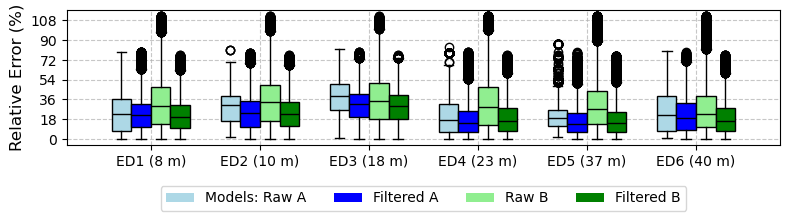

In [24]:
# Box plot visualization for relative errors per device (with IQR filtering)

# Define the IQR filtering function
def filter_outliers_iqr(df, cols, multiplier=1.5):
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Assume 'error_df' is your existing DataFrame
cols_to_check = ['raw_error_A', 'filtered_error_A', 'raw_error_B', 'filtered_error_B']
iqr_filtered_df = filter_outliers_iqr(error_df, cols_to_check)

fig, ax = plt.subplots(figsize=(8, 3))

# Sort devices by mean distance
devices_sorted = iqr_filtered_df.groupby('device_id')['distance'].mean().sort_values().index
positions = np.arange(len(devices_sorted))
box_width = 0.18

colors = ['lightblue', 'blue', 'lightgreen', 'green']

# Plot boxplots for each device
for idx, device in enumerate(devices_sorted):
    device_data = iqr_filtered_df[iqr_filtered_df['device_id'] == device]

    data_to_plot = [
        device_data['raw_error_A'],
        device_data['filtered_error_A'],
        device_data['raw_error_B'],
        device_data['filtered_error_B']
    ]

    pos = positions[idx] + np.array([-1.5, -0.5, 0.5, 1.5]) * box_width
    bp = ax.boxplot(data_to_plot, positions=pos, widths=box_width, patch_artist=True,
                    medianprops=dict(color='black'))

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# Legend: "Models:" on the same line as the first label
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color) for color in colors]
labels = ['Models: Raw A', 'Filtered A', 'Raw B', 'Filtered B']
ax.legend(handles, labels, fontsize=10, loc='upper center',
          bbox_to_anchor=(0.5, -0.25), ncol=4)

# X-axis labels: "ED1 (8 m)", "ED2 (10 m)", etc.
device_labels = [
    f'ED{idx+1} ({int(iqr_filtered_df[iqr_filtered_df["device_id"] == device]["distance"].iloc[0])} m)'
    for idx, device in enumerate(devices_sorted)
]
ax.set_xticks(positions)
ax.set_xticklabels(device_labels, fontsize=10)

# More y-axis ticks: set major tick spacing to 5 (adjust as needed)
ax.yaxis.set_major_locator(ticker.MultipleLocator(18))


ax.set_ylabel('Relative Error (%)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout so legend has room below the plot
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()


In [25]:
# Compute mean relative errors per device after robust IQR filtering
mean_errors_per_device = iqr_filtered_df.groupby('device_id')[cols_to_check].mean().round(2)

# Compute overall mean relative errors across all devices
overall_mean_errors = iqr_filtered_df[cols_to_check].mean().round(2)

# Display results 
print("\nMean Relative Errors (%) per Device:\n")
display(mean_errors_per_device)
print("\nOverall Mean Relative Errors (%):\n")
print(overall_mean_errors)


Mean Relative Errors (%) per Device:



,raw_error_A,filtered_error_A,raw_error_B,filtered_error_B
device_id,,,,
ED0,27.57,23.97,34.01,23.52
ED1,23.28,23.61,32.90,22.76
ED2,20.02,18.21,33.01,20.01
ED3,36.14,30.37,35.76,28.90
ED4,18.92,16.47,31.36,17.49
ED5,25.59,22.08,28.08,19.37



Overall Mean Relative Errors (%):

raw_error_A         25.29
filtered_error_A    22.41
raw_error_B         32.40
filtered_error_B    21.91
dtype: float64


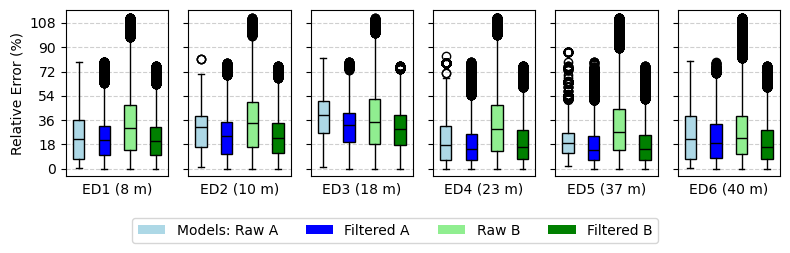

In [26]:
# Box plot visualization for relative errors per device (with IQR filtering)

# Define the IQR filtering function

def filter_outliers_iqr(df, cols, multiplier=1.5):
    """    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing error columns to be filtered.
    cols : list of str
        The column names in `df` on which to apply the IQR filtering.
    multiplier : float, optional (default=1.5)
        The multiplier for the IQR to determine outlier boundaries.
        
    Returns:
    --------
    filtered_df : pd.DataFrame
        A copy of the input DataFrame with outliers removed based on IQR filtering.
    """
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Apply filtering to relative_error_df
cols_to_check = ['raw_error_A', 'filtered_error_A', 'raw_error_B', 'filtered_error_B']
robust_relative_error_df = filter_outliers_iqr(error_df, cols_to_check)

# Create one row of 6 subplots
fig, axes = plt.subplots(1, 6, figsize=(8, 2.4), sharey=True)

# Sort devices by mean distance
devices_sorted = robust_relative_error_df.groupby('device_id')['distance'].mean().sort_values().index

# Loop through each device and plot 4 boxplots (Raw A, Filtered A, Raw B, Filtered B)
for idx, device in enumerate(devices_sorted):
    device_data = robust_relative_error_df[robust_relative_error_df['device_id'] == device]
    
    data_to_plot = [
        device_data['raw_error_A'],
        device_data['filtered_error_A'],
        device_data['raw_error_B'],
        device_data['filtered_error_B']
    ]
    
    bp = axes[idx].boxplot(
        data_to_plot,
        patch_artist=True,
        medianprops=dict(color='black')
    )
    
    # Color the boxes (two for Model A, two for Model B)
    box_colors = ['lightblue', 'blue', 'lightgreen', 'green']
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    
    # Remove numeric x-tick labels (1, 2, 3, 4) so only the device label remains
    axes[idx].set_xticks([])
    axes[idx].set_xticklabels([])

    # Set device label as the x-axis label
    distance_val = int(device_data["distance"].iloc[0])
    axes[idx].set_xlabel(f'ED{idx+1} ({distance_val} m)', fontsize=10)
    
    # Only the first (leftmost) subplot gets a y-axis label to avoid repetition
    if idx == 0:
        axes[idx].set_ylabel('Relative Error (%)')
    else:
        axes[idx].set_ylabel('')
    
    # Grid for better readability
    axes[idx].grid(True, linestyle='--', alpha=0.6)

# Create a single legend for the entire figure
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color) for color in box_colors]
labels = ['Models: Raw A', 'Filtered A', 'Raw B', 'Filtered B']
fig.legend(handles, labels, fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)

# Increase y-axis tick density if desired
for ax in axes:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(18))

# Adjust layout to fit legend and labels
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

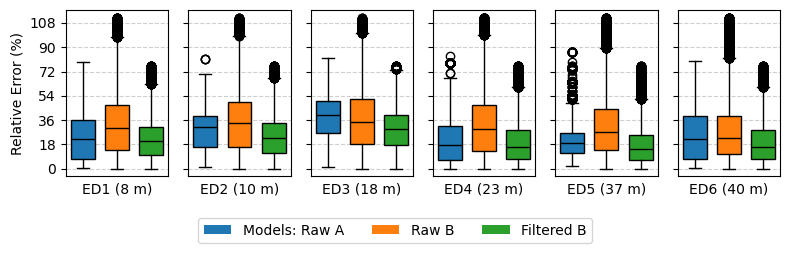

In [27]:
# Box plot visualization for relative errors per device (with IQR filtering)

# Define the IQR filtering function
def filter_outliers_iqr(df, cols, multiplier=1.5):
    """    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing error columns to be filtered.
    cols : list of str
        The column names in `df` on which to apply the IQR filtering.
    multiplier : float, optional (default=1.5)
        The multiplier for the IQR to determine outlier boundaries.
        
    Returns:
    --------
    filtered_df : pd.DataFrame
        A copy of the input DataFrame with outliers removed based on IQR filtering.
    """
    filtered_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Apply filtering to relative_error_df
cols_to_check = ['raw_error_A', 'filtered_error_A', 'raw_error_B', 'filtered_error_B']
robust_relative_error_df = filter_outliers_iqr(error_df, cols_to_check)

# Create one row of 6 subplots
fig, axes = plt.subplots(1, 6, figsize=(8, 2.4), sharey=True)

# Sort devices by mean distance
devices_sorted = robust_relative_error_df.groupby('device_id')['distance'].mean().sort_values().index

# Loop through each device and plot 3 boxplots (Raw A, Raw B, Filtered B)
for idx, device in enumerate(devices_sorted):
    device_data = robust_relative_error_df[robust_relative_error_df['device_id'] == device]
    
    data_to_plot = [
        device_data['raw_error_A'],       # Raw A
        device_data['raw_error_B'],       # Raw B
        device_data['filtered_error_B']   # Filtered B
    ]
    
    bp = axes[idx].boxplot(
        data_to_plot,
        patch_artist=True,
        medianprops=dict(color='black'),
        widths=0.7
    )
    
    # Color the boxes (Raw A in lightblue, Raw B in lightgreen, Filtered B in green)
    #box_colors = ['lightblue', 'lightgreen', 'green']
    box_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    
    # Remove numeric x-tick labels (1, 2, 3) so only the device label remains
    axes[idx].set_xticks([])
    axes[idx].set_xticklabels([])

    # Set device label as the x-axis label
    distance_val = int(device_data["distance"].iloc[0])
    axes[idx].set_xlabel(f'ED{idx+1} ({distance_val} m)', fontsize=10)
    
    # Only the first (leftmost) subplot gets a y-axis label to avoid repetition
    if idx == 0:
        axes[idx].set_ylabel('Relative Error (%)')
    else:
        axes[idx].set_ylabel('')
    
    # Grid for better readability
    axes[idx].grid(True, linestyle='--', alpha=0.6)

# Create a single legend for the entire figure
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color) for color in box_colors]
labels = ['Models: Raw A', 'Raw B', 'Filtered B']  # Removed "Filtered A"
fig.legend(handles, labels, fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)

# Increase y-axis tick density if desired
for ax in axes:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(18))

# Adjust layout to fit legend and labels
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig('../all_data_files/Localization/relative_errors_boxplots_per_device.png', dpi=1000, bbox_inches='tight')
plt.show()